# DAT 494 Final Project
By Tom O Connell & Regis Wang

## Abstract
Air pollution has been a rising problem ever since the era of the industrial revolution. The fuels used to power our daily lives possess dire consequences to our environment. Our group is interested in looking at the air quality in the United States. We split this project into two parts, we will first be looking at the emissions - specifically carbon dioxide and nitrogen dioxide and sulfur dioxide - caused by plants of various fuels. Then, we will be comparing the emissions to the overall air quality for further analysis into how both of these emissions affect the overall air quality. To do this, we are using the eGrid data provided in one of our previous labs, and use both PLNT21 and ST21 to grab the correct data. We will also use the AQI data provided by the EPA and merge them together to get a full picture of our analysis, where we will then perform exploratory data analysis. For further clarity, we will also be comparing two years: 2000 and 2021 to see how the emissions have changed and affected the air quality throughout the years. We found that the correlation between states with large amounts of generators and bad AQI is unstable, hence proving that other factors may influence a state's AQI.

## Introduction
Air pollutants caused by fuel plants emissions have a lasting impact on the environment. We wanted to take a look geographically the exact impact it has and visualize the data to provide a more thorough look into the emissions, specifically in the US. There are many substances that could be classified as an air pollutant. We decided to take a look at three specifically: Carbon dioxide, nitrogen dioxide, and sulfur dioxide. Cetin and Sevik noted in their research that “Of all CO2 in the atmosphere, 80 to 85% are a result of fossil fuels, while 15 to 20% stem from organic respiration and microscopic organisms, which degrade organic matter” (Cetin, 2017). As a main culprit of air pollution and atmospheric changes, carbon dioxide is a huge air pollutant caused by virtually everything we do these days. Our daily lives are constantly powered by the burning of fossil fuels that end up releasing carbon dioxide among other gasses into the atmosphere. Meanwhile, Nitrogen dioxide is not only a result of fossil fuels, but also a result of burning gas in our vehicles. As another side product of fuel production, nitrogen dioxide is another pollutant that can affect air quality, as Moshammer states in his research, “the general scientific consensus appears to be that NO2 is a valuable proxy of high-resolution spatial distribution of poor air quality” (Karaca, 2020). 

Throughout the years, researchers have noticed the decreases in carbon dioxide emissions due to the rising awareness of global warming and its effects on the environment. Political viewpoints aside, Feng et al. has noted that they have seen a decrease in levels due to Obama’s administration stating goals to reduce these emissions. However, they wanted to explore the “quantitative analysis of whether the gas boom and changes in the fuel mix of the power sector are indeed driving the decrease in US CO2 emissions” (Liu, 2015). The results showed that while population growth was increasing CO2 emissions, the changes in production structure and fuel mix served to decrease the overall CO2 emissions in the US (Liu, 2015). Similarly, although not in the US, Carslaw et al. found that while the vehicles driven in the UK had high proportions of nitrogen oxides, the absolute amount had been reduced since around 2007 (Carslaw, 2019). Another research study done by Xiu and Xiang looked at the carbon dioxide and nitrogen dioxide levels in the ten biggest states by population, stating the “areas wherein human activity is markedly intense and are indicators of anthropogenic impact” (Xu, Xiang, 2024). They found in these states, the peak carbon dioxide levels were during the spring season, while the troughs were during the summer. For nitrogen dioxide levels, high concentrations were observed during the winter, and low levels in the summer. 




## Methods

## Import Libraries
Lets first start by importing the necessary libraries in order to import our data, and visualize our plots and charts.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import censusgeocode as cg

import pandas as pd
import geopandas as gpd

from mpl_toolkits.axes_grid1 import make_axes_locatable

import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import rasterio.mask

from rasterio.warp import calculate_default_transform, reproject, Resampling

import xarray as xr
import rioxarray as rxr

import esda
from splot.esda import plot_moran

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from splot import esda as esdaplot

import contextily as cx

import plotly.express as px

from rasterstats import zonal_stats, point_query

## Prepare GDFs
Now let's load the state and county gdf files so we can later merge our dataframes with them to create visually appealing plots and graphs

### Load State and County GDF

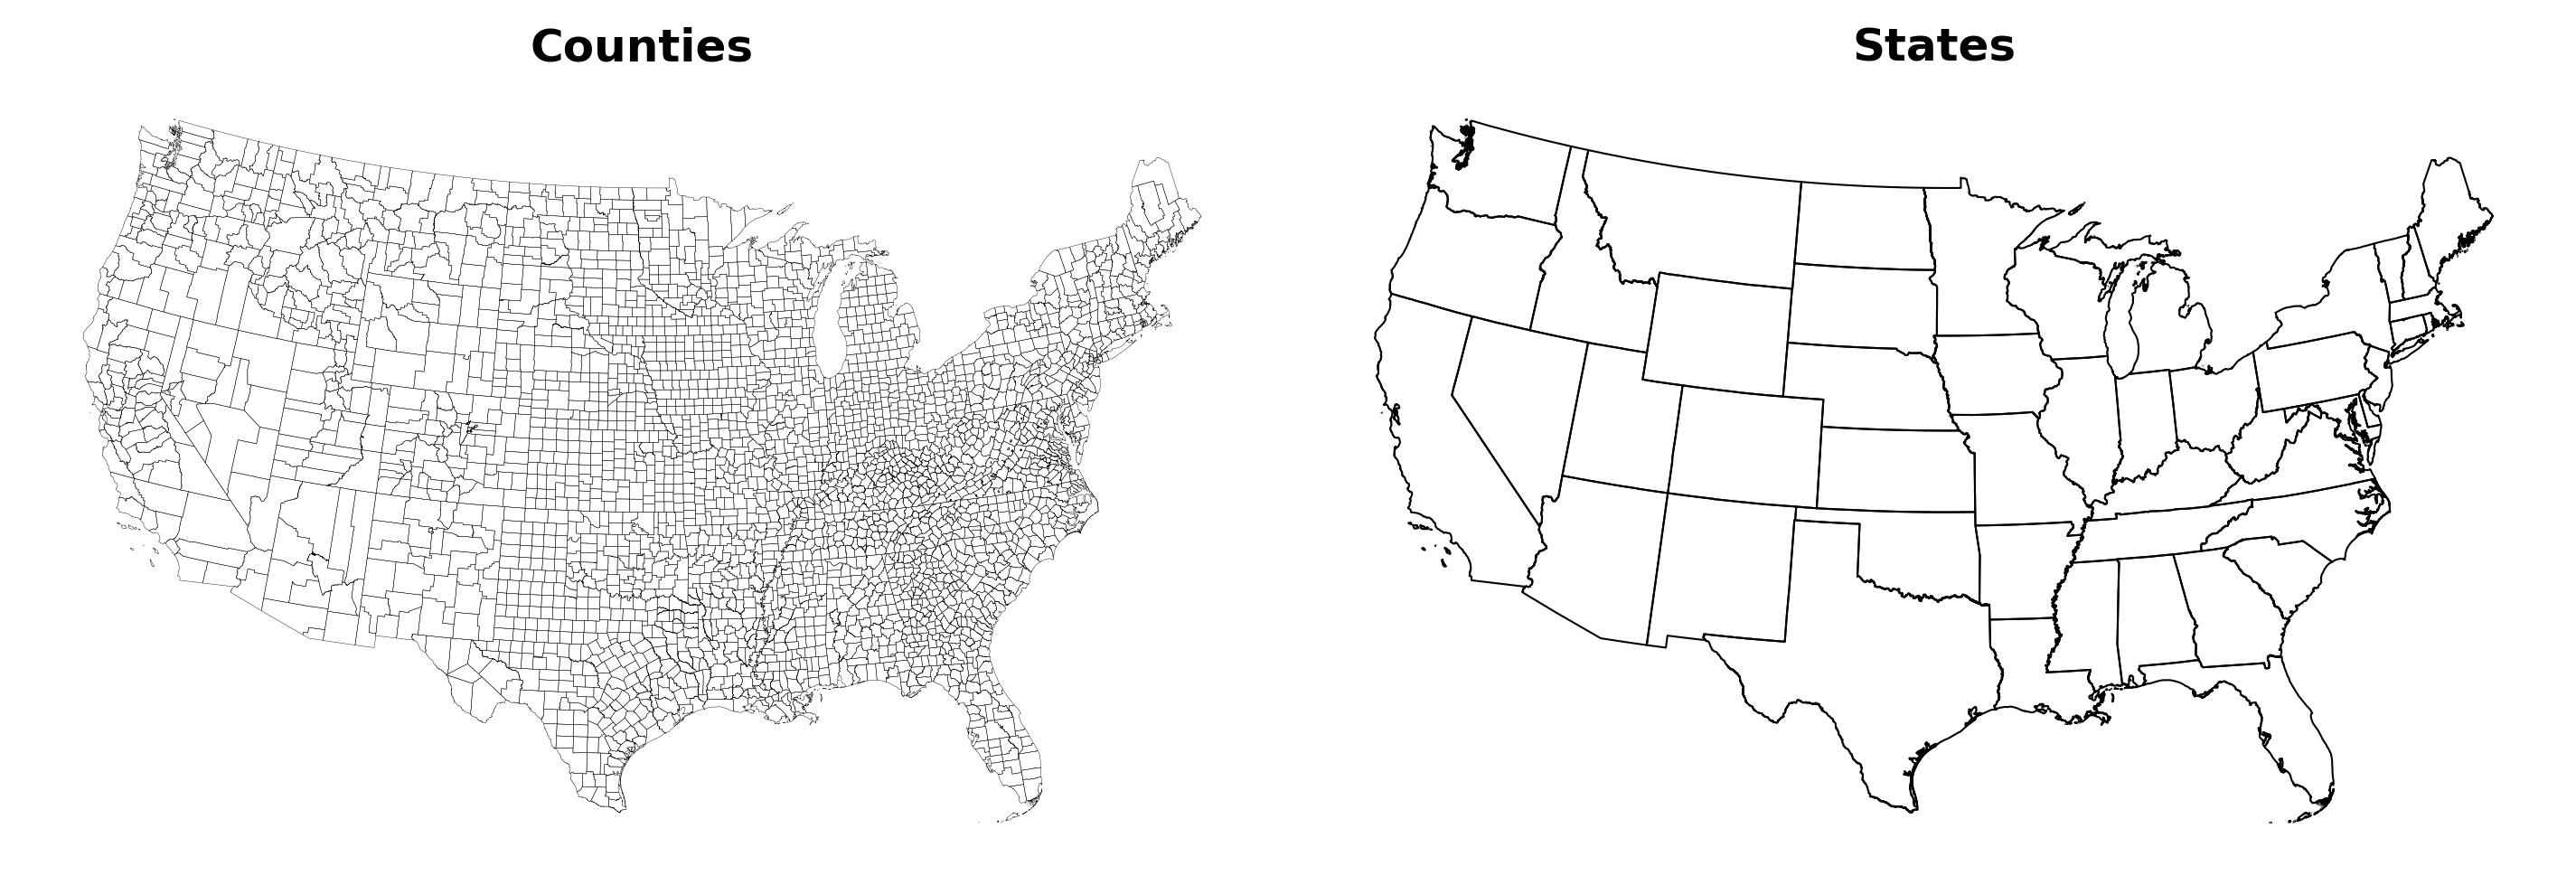

In [3]:
url_county = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_500k.zip'
county_gdf = gpd.read_file(url_county)

#And the states:
url_county = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip'
state_gdf = gpd.read_file(url_county)


#Exclude everthing outside the contiguous US:
exclude_list = [15, 72, 2, 60, 66, 69, 78]
county_gdf = county_gdf.loc[~county_gdf['STATEFP'].astype(int).isin(exclude_list)]
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].astype(int).isin(exclude_list)]


#And convert to CRS EPSG:4326:
county_gdf = county_gdf.to_crs(5070) 
state_gdf = state_gdf.to_crs(5070)


#Throw in a FIPS code for the county_gdf:
county_gdf['FIPS'] = county_gdf.STATEFP + county_gdf.COUNTYFP

#A quick plot to check:
#####
fig, ax1 = plt.subplots(1, 2, figsize=(12, 8), dpi=300)

county_gdf.plot(ax = ax1[0], linewidth = .1, edgecolor = 'black', facecolor='none')
state_gdf.plot(ax = ax1[1], linewidth = .5, edgecolor = 'black', facecolor='none')

ax1[0].set_title('Counties', fontweight='bold');
ax1[1].set_title('States', fontweight='bold');
ax1[0].set_axis_off()
ax1[1].set_axis_off()

plt.subplots_adjust(wspace=0.05) 

## Prepare  eGRID Dataset
Let's load in our first dataset, the 2021 eGRID data found here: https://www.epa.gov/egrid/download-data. The Emissions & Generation Resource Integrated Database (eGRID) is a comprehensive source of data on the environmental characteristics of almost all electric power generated in the United States. The preeminent source of emissions data for the electric power sector, eGRID is based on available plant-specific data for all U.S. electricity generating plants that provide power to the electric grid and report data to the U.S. government

Data reported include, but are not limited to, net electric generation; resource mix (for renewable and nonrenewable generation); mass emissions of carbon dioxide (CO2), nitrogen oxides (NOx), sulfur dioxide (SO2), methane (CH4), nitrous oxide (N2O), and mercury (Hg); emission rates for CO2, NOx, SO2, CH4, and N2O; heat input; and nameplate capacity. eGRID reports this information on an annual basis (as well as by ozone season for NOx) at different levels of aggregation. We will focus heavily on the mass emissions of CO2, NOx and SO2 later on.

In [107]:
path = "eGRID2021_data.xlsx"

df = pd.read_excel(path, sheet_name = 'PLNT21', skiprows = 1)

gdf = df[['NAMEPCAP', 'PSTATABB', 'PLFUELCT', 'PLNOXAN', 'PLNGENAN', 'PLCO2AN', 'PLSO2RTA', 'NUMGEN', 'LON', 'LAT']]
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(df['LON'], df['LAT']), crs='EPSG:4326')

conus = gdf[~gdf['PSTATABB'].isin(['AK', 'HI', 'PR'])]
conus = conus[conus['PLNGENAN'] >= 0]

conus = conus.to_crs('EPSG:5070')

path1 = "eGRID2021_data.xlsx"

df1 = pd.read_excel(path1, sheet_name = 'ST21', skiprows = 1)


## Filter to only Coal and Gas Plants
According to eia.gov, fossil fuel combustion (burning) for energy accounted for 73% of total GHG emissions and for 92% of total U.S. anthropogenic CO2 emissions in the United States.

Now that we know this, let's filter the dataframe to only contain coal and gas plants.

In [108]:
coalgas = conus[conus['PLFUELCT'].isin(['COAL', 'GAS'])]
coal = coalgas[coalgas['PLFUELCT'] == 'COAL']
gas = coalgas[coalgas['PLFUELCT'] == 'GAS']

coalgasdf = coalgas.groupby('PSTATABB').sum(numeric_only=True).reset_index()

coalgasgdf = state_gdf.merge(coalgasdf, left_on='STUSPS', right_on='PSTATABB', how='left')

coalgasgdf = coalgasgdf.merge(df1, left_on='PSTATABB', right_on='PSTATABB', how='left')


## Number of Generators in the United States

For our project, we wanted to explore the production of greenhouse gases, specifically CO2, NOx and SO2, from coal and gas plants in the United States. Lets first look at the amount of genrators per state in the United States as this might give us an insight into which states will ahve the most emissions. 

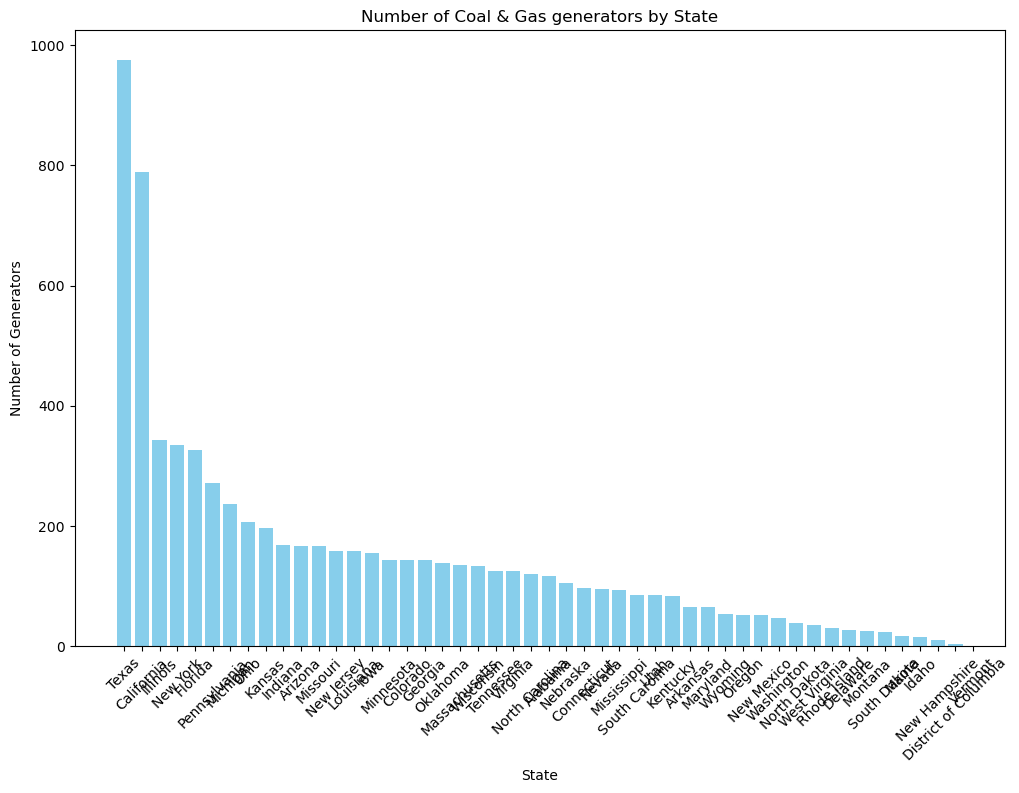

In [51]:
generators_for_plotting2021 = coalgasgdf[['NAME', 'NUMGEN']]

generators_for_plotting2021 = generators_for_plotting2021.sort_values('NUMGEN', ascending=False)


fig, ax = plt.subplots(1, 1, figsize=(12, 8)) 

ax.bar(generators_for_plotting2021['NAME'], generators_for_plotting2021['NUMGEN'], color='skyblue')
ax.set_title('Number of Coal & Gas generators by State')
ax.set_xlabel('State')
ax.set_ylabel('Number of Generators')
ax.tick_params(axis='x', rotation=45) 

plt.show()

## Number of Generators vs CO2 Emissions per State
Now lets look at the amount of CO2 produced vs the amount of generators per state. As expected, the states with the most generators produce the most CO2.

In [52]:
fig = px.scatter(coalgasgdf, x='NUMGEN', y='STCO2AN', 
                 hover_data=['NAME'],  
                 title='Number of Generators vs CO2 Emissions per State')

fig.update_layout(xaxis_title='Number of Generators',
                  yaxis_title='CO2 Emissions in Tons',
                  margin=dict(l=40, r=40, t=40, b=40))

fig.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers'))

fig.show()

## Almost Linear Fit
As you can see from the graph below, the number of generators vs emissions per state is almost a linear fit with a few outliers. This shows the high correspondance between CO2 Emissions and number of generators within plants.

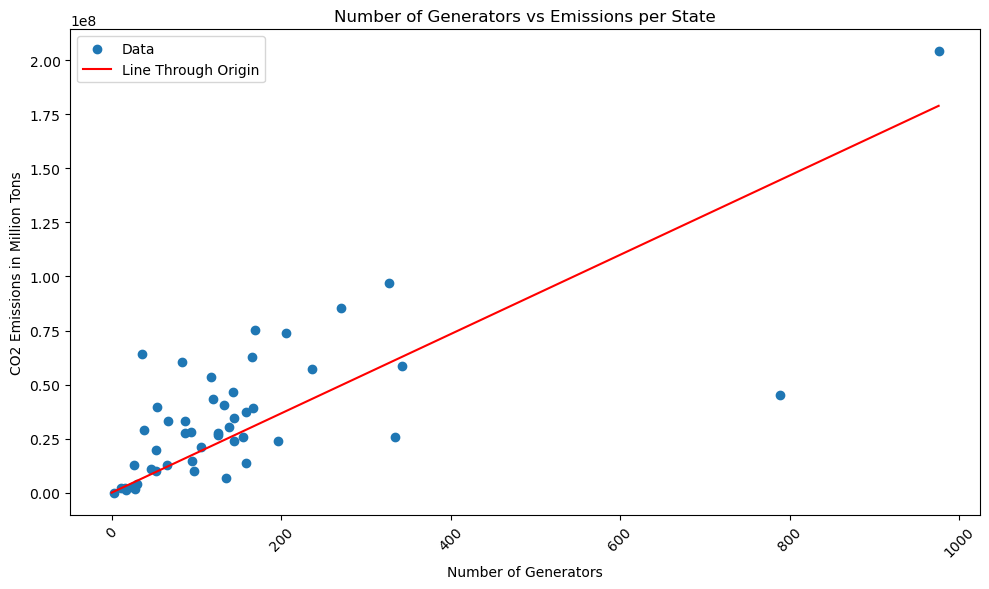

In [53]:
x = coalgasgdf['NUMGEN']
y = coalgasgdf['PLCO2AN']
slope = np.sum(x*y) / np.sum(x*x) 

plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data')

x_vals = np.array([0, max(x)])  
y_vals = slope * x_vals  
plt.plot(x_vals, y_vals, color='red', label='Line Through Origin')  

plt.title('Number of Generators vs Emissions per State')
plt.xlabel('Number of Generators')
plt.ylabel('CO2 Emissions in Million Tons')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()


## Filtering out the Greenhouse gases

Now let's explore each greenhouse gas individually.

From our graphs below, we can see the difference in CO2 emissions as opposed to NOx and SO2 emissions in the coal and gas plants of the United States. It is extremely apparent that the levels of CO2, NOx, and SO2 produced by coal plants far exceeds the amount produced by gas plants. 

While NOx levels may seem low in comparison to CO2, the effect of NOx on the atmosphere is far greater. According to the EPA, 'The impact of 1 pound of N20 on warming the atmosphere is 265 times that of 1 pound of carboin dioxide'.

Similarily, while SO2 levels appear low, their effect is massive on the environment. SO2 can cause acid rain which seriously affects ecosystems. Acid rain is a major problem in the northern hemisphere where trees and whole forests have been affected

(-2586829.4388886895,
 2488915.8729062304,
 124423.84046021817,
 3317717.6387093915)

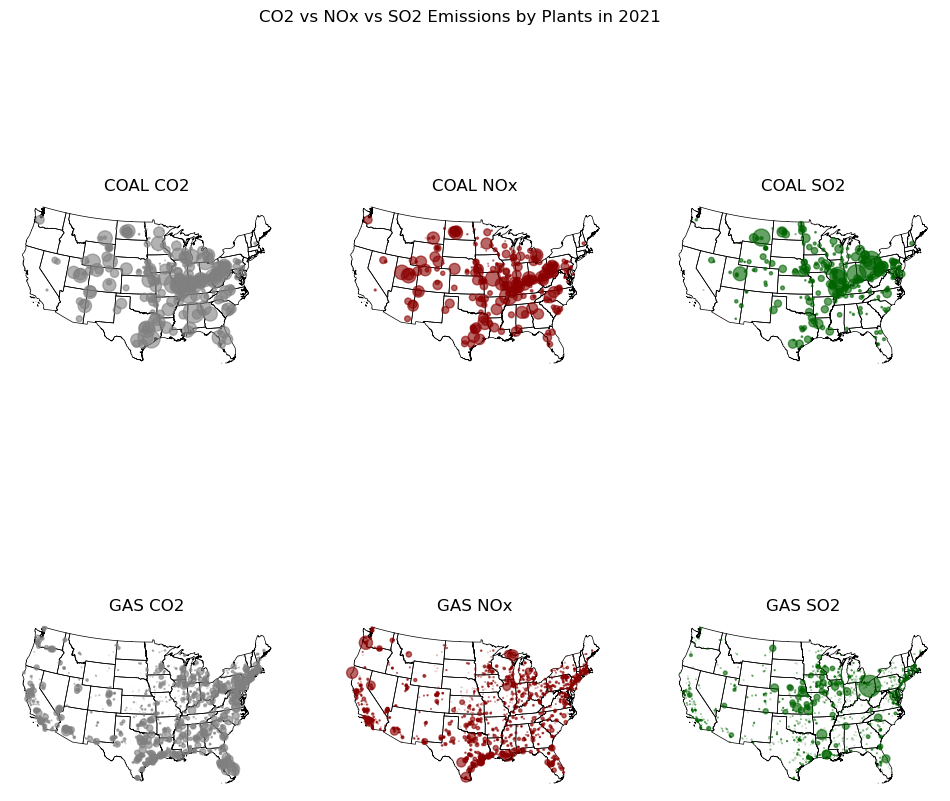

In [54]:
fig1, axs1 = plt.subplots(2, 3, figsize=(12, 10))
fig1.suptitle('CO2 vs NOx vs SO2 Emissions by Plants in 2021')

custom_map = ListedColormap(['gray'])
custom_map1 = ListedColormap(['darkred'])
custom_map2 = ListedColormap(['darkgreen'])

state_gdf.plot(ax = axs1[0,0], linewidth = .5, edgecolor = 'black', facecolor = 'none')
state_gdf.plot(ax = axs1[0,1], linewidth = .5, edgecolor = 'black', facecolor = 'none')
state_gdf.plot(ax = axs1[0,2], linewidth = .5, edgecolor = 'black', facecolor = 'none')
state_gdf.plot(ax = axs1[1,0], linewidth = .5, edgecolor = 'black', facecolor = 'none')
state_gdf.plot(ax = axs1[1,1], linewidth = .5, edgecolor = 'black', facecolor = 'none')
state_gdf.plot(ax = axs1[1,2], linewidth = .5, edgecolor = 'black', facecolor = 'none')

coal = coalgas[coalgas['PLFUELCT'] == 'COAL']
gas = coalgas[coalgas['PLFUELCT'] == 'GAS']

coal.plot(ax = axs1[0,0], markersize = coal['PLCO2AN']/100000, cmap = custom_map, alpha = 0.6)
coal.plot(ax = axs1[0,1], markersize = coal['PLNOXAN']/100, cmap = custom_map1, alpha = 0.6)
coal.plot(ax = axs1[0,2], markersize = coal['PLSO2RTA'] * 5, cmap = custom_map2, alpha = 0.6)

gas.plot(ax = axs1[1,0], markersize = gas['PLCO2AN']/100000, cmap = custom_map, alpha = 0.6)
gas.plot(ax = axs1[1,1], markersize = gas['PLNOXAN']/100, cmap = custom_map1, alpha = 0.6)
gas.plot(ax = axs1[1,2], markersize = gas['PLSO2RTA'] * 5, cmap = custom_map2, alpha = 0.6)

axs1[0,0].set_title("COAL CO2")
axs1[0,1].set_title("COAL NOx")
axs1[0,2].set_title("COAL SO2")
axs1[1,0].set_title("GAS CO2")
axs1[1,1].set_title("GAS NOx")
axs1[1,2].set_title("GAS SO2")
axs1[0,0].axis("off")
axs1[0,1].axis("off")
axs1[0,2].axis("off")
axs1[1,0].axis("off")
axs1[1,1].axis("off")
axs1[1,2].axis("off")


## States Emissions
Now lets look at states emissions of CO2, NOx and SO2 to get a more detailed view of the top contributors to the production of these greenhouse gases

### Load the eGRID Data

In [95]:
path = "eGRID2021_data.xlsx"

df1 = pd.read_excel(path, sheet_name = 'ST21', skiprows = 1)

gdf1 = df1[['PSTATABB', 'FIPSST', 'STNOXAN', 'STCO2AN', 'STSO2AN']]

state_emissions_gdf = state_gdf.merge(df1, left_on='STUSPS', right_on='PSTATABB', how='left')




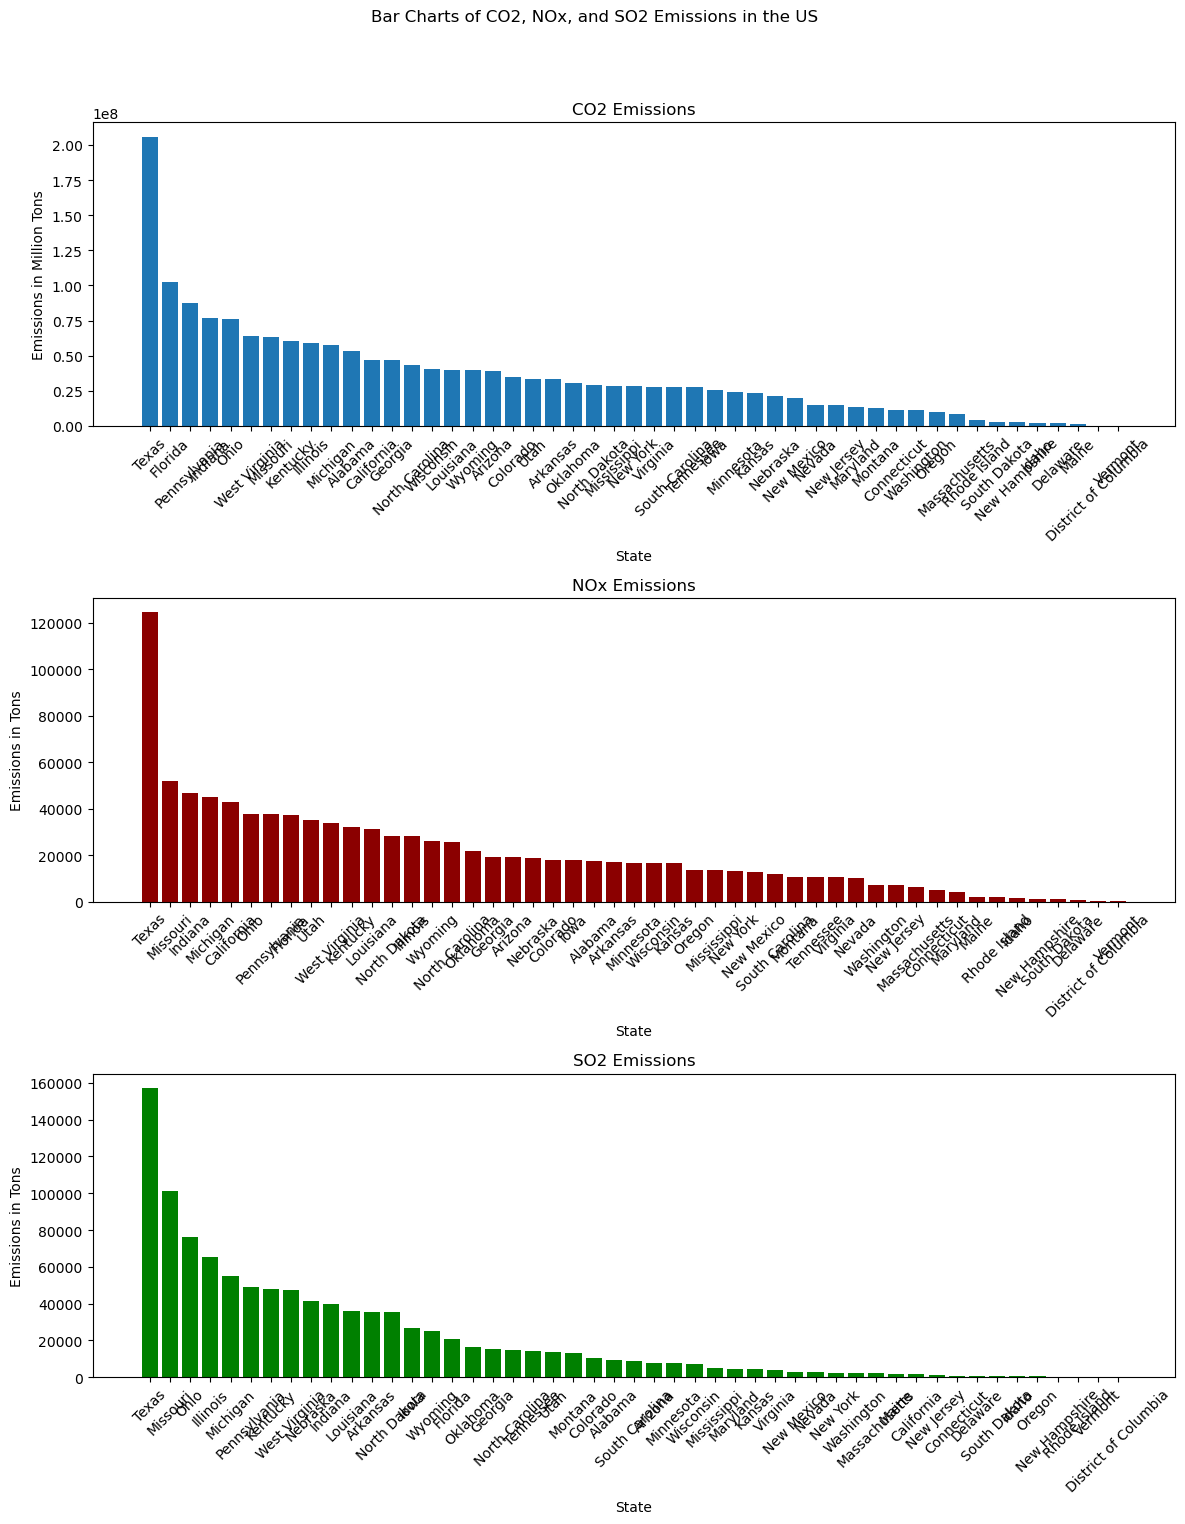

In [96]:
fig, axs = plt.subplots(3, 1, figsize=(12, 16))
fig.suptitle('Bar Charts of CO2, NOx, and SO2 Emissions in the US')


co2emissions_for_plotting = state_emissions_gdf.sort_values('STCO2AN', ascending=False)
noxemissions_for_plotting = state_emissions_gdf.sort_values('STNOXAN', ascending=False)
so2emissions_for_plotting = state_emissions_gdf.sort_values('STSO2AN', ascending=False)


axs[0].bar(co2emissions_for_plotting['NAME'], co2emissions_for_plotting['STCO2AN'])
axs[0].set_title('CO2 Emissions')
axs[0].set_ylabel('Emissions in Million Tons')
axs[0].set_xlabel('State')
axs[0].tick_params(axis='x', rotation=45)

# NOx 
axs[1].bar(noxemissions_for_plotting['NAME'], noxemissions_for_plotting['STNOXAN'], color='darkred')
axs[1].set_title('NOx Emissions')
axs[1].set_xlabel('State')
axs[1].set_ylabel('Emissions in Tons')
axs[1].tick_params(axis='x', rotation=45)

# SO2 
axs[2].bar(so2emissions_for_plotting['NAME'], so2emissions_for_plotting['STSO2AN'], color='green')
axs[2].set_title('SO2 Emissions')
axs[2].set_xlabel('State')
axs[2].set_ylabel('Emissions in Tons')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## Population 

Let's load a new dataset, the 2019 Census datset.

We can later use this to see the emission amounts compared to the population of each state

In [97]:
url_name = r'https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020-alldata.csv'

#Note the encoding:
df = pd.read_csv(url_name, encoding = "ISO-8859-1", engine='python')

#Create the FIPS:
df['FIPS'] = df.STATE.astype(str).str.zfill(2) + df.COUNTY.astype(str).str.zfill(3)

## And merge:
county_gdf = county_gdf.merge(df, left_on='FIPS', right_on='FIPS', how='left')


## Cleaning

Let's clean the data and merge it to the state_emissions_gdf. Doing this allows us to later plot it on maps of the US. Let's also create the variables of CO2PP, NOxPP and SO2PP. 
These variables represent the amount of CO2, NOx and SO2 per person is produced in each state. 

In [98]:

statepopulation = df

statepopulation['CENSUS2010POP'] = pd.to_numeric(statepopulation['CENSUS2010POP'], errors='coerce')
statepopulation = df.groupby('STNAME')['CENSUS2010POP'].sum(numeric_only=True).reset_index()


state_population_gdf = state_emissions_gdf.merge(statepopulation, left_on='NAME', right_on='STNAME', how='left')


state_population_gdf['CO2PP'] = state_population_gdf['STCO2AN'] / state_population_gdf['CENSUS2010POP']
state_population_gdf['NOxPP'] = state_population_gdf['STNOXAN'] / state_population_gdf['CENSUS2010POP']
state_population_gdf['SO2PP'] = state_population_gdf['STSO2AN'] / state_population_gdf['CENSUS2010POP']


Now let's plot...

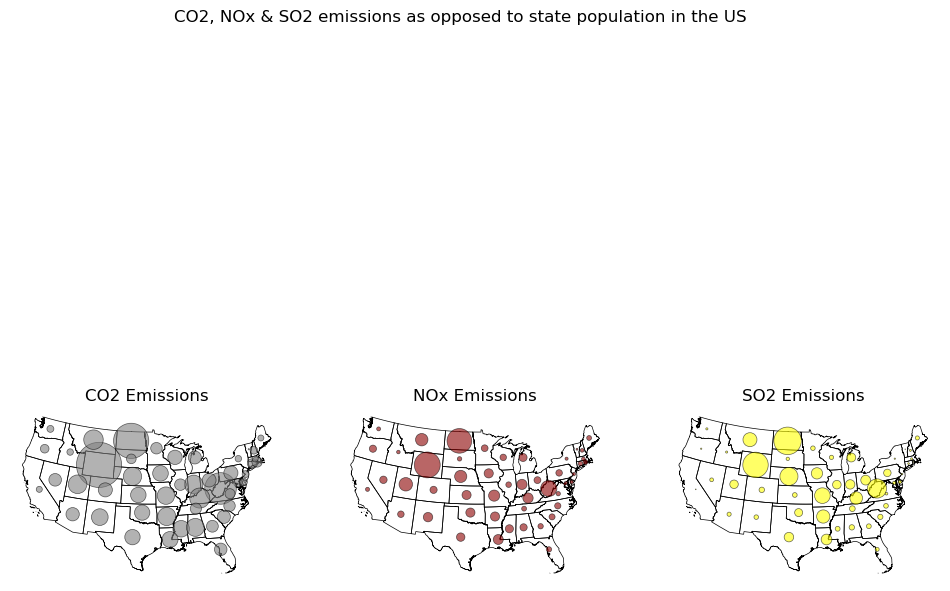

In [99]:
state_population_gdf['centroids'] = state_population_gdf.centroid
state_population_gdf['longitude'] = state_population_gdf.centroids.x
state_population_gdf['latitude'] = state_population_gdf.centroids.y

fig, axs = plt.subplots(1, 3, figsize=(12, 10))
fig.suptitle('CO2, NOx & SO2 emissions as opposed to state population in the US')

state_gdf.plot(ax=axs[0], linewidth=0.5, edgecolor='black', facecolor='none')
state_gdf.plot(ax=axs[1], linewidth=0.5, edgecolor='black', facecolor='none')
state_gdf.plot(ax=axs[2], linewidth=0.5, edgecolor='black', facecolor='none')

axs[0].scatter(state_population_gdf['longitude'], state_population_gdf['latitude'],
               s=state_population_gdf['CO2PP']*30, alpha=0.6, color='gray', edgecolor='black', linewidth=0.5)
axs[0].set_title('CO2 Emissions')

axs[1].scatter(state_population_gdf['longitude'], state_population_gdf['latitude'],
               s=state_population_gdf['NOxPP']*15000, alpha=0.6, color='darkred', edgecolor='black', linewidth=0.5)
axs[1].set_title('NOx Emissions')

axs[2].scatter(state_population_gdf['longitude'], state_population_gdf['latitude'],
               s=state_population_gdf['SO2PP']*15000, alpha=0.6, color='yellow', edgecolor='black', linewidth=0.5)
axs[2].set_title('SO2 Emissions')

axs[0].axis("off")
axs[1].axis("off")
axs[2].axis("off")
plt.show()
                      
                    

## Bar Chart
Now lets look at the data on a bar chart for better visualization

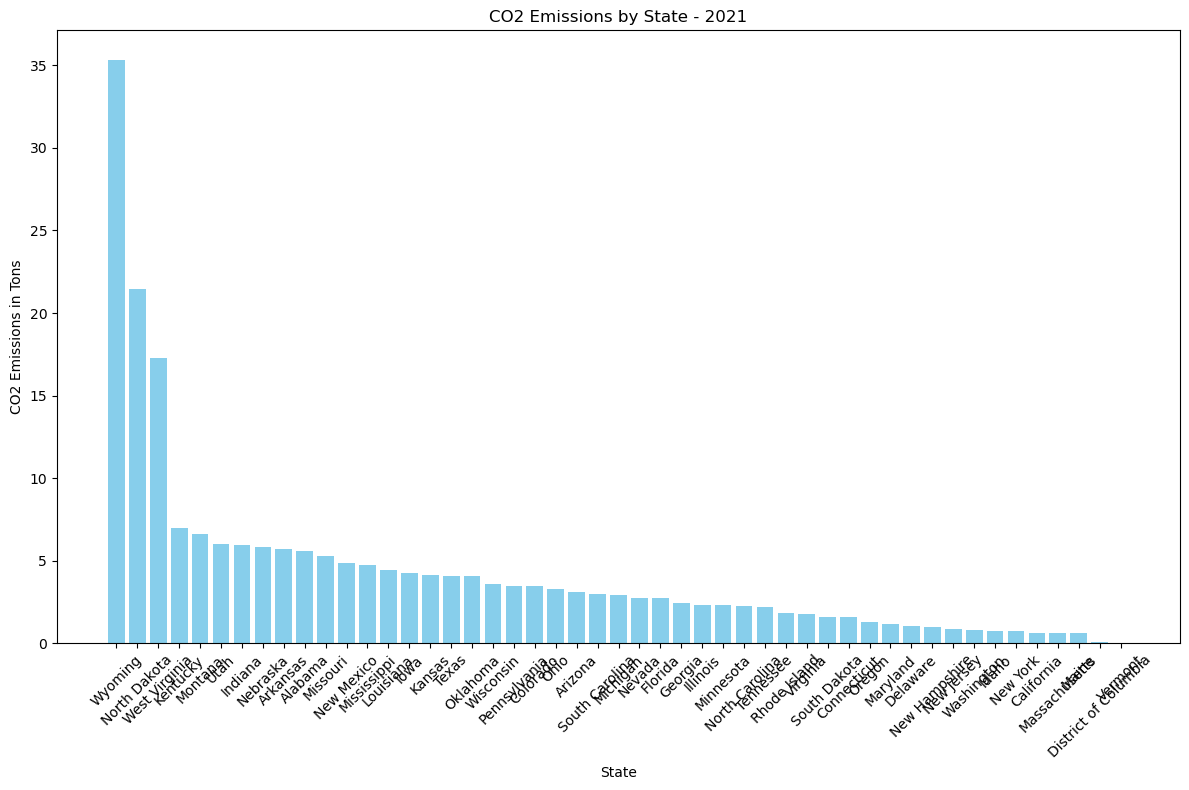

In [100]:
data_for_plotting2021 = state_population_gdf[['NAME', 'CO2PP']]

data_for_plotting2021 = data_for_plotting2021.sort_values('CO2PP', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 8)) 

ax.bar(data_for_plotting2021['NAME'], data_for_plotting2021['CO2PP'], color='skyblue')
ax.set_title('CO2 Emissions by State - 2021')
ax.set_xlabel('State')
ax.set_ylabel('CO2 Emissions in Tons')
ax.tick_params(axis='x', rotation=45)  
ax.tick_params(axis='x', rotation=45)  
plt.tight_layout()  
plt.show()

## AQI
Finally, let load our last two datasets 'annual aqi of 2021' and 'annual aqi of 2000'.

We wanted to load the 2000 dataset to see if air quality has improved/worsened in the past 20 years. Given the bigger emphasis and publicity of Climate Change, we would hope that air quality has improved as we move away from fossil fuels.

In [101]:
path1 = "annual_aqi_by_county_2021.csv"
path2 = "annual_aqi_by_county_2000.csv"

airdf2000 = pd.read_csv(path2)
airdf2021 = pd.read_csv(path1)



Lets clean our data by removing states outside the United States and create average AQI columns.

In [102]:
average_2021_AQI = airdf2021.groupby('State')['Median AQI'].mean().reset_index()
average_2000_AQI = airdf2000.groupby('State')['Median AQI'].mean().reset_index()


rows_to_remove = ['Country Of Mexico', 'Puerto Rico', 'Alaska', 'Hawaii']
AQI_2021_filtered = average_2021_AQI[~average_2021_AQI['State'].isin(rows_to_remove)]
AQI_2021_filtered = AQI_2021_filtered.reset_index(drop=True)

AQI_2000_filtered = average_2000_AQI[~average_2000_AQI['State'].isin(rows_to_remove)]
AQI_2000_filtered = AQI_2000_filtered.reset_index(drop=True)


state_aqi_2021_gdf = state_emissions_gdf.merge(AQI_2021_filtered, left_on='NAME', right_on='State', how='left')
state_aqi_2000_gdf = state_emissions_gdf.merge(AQI_2000_filtered, left_on='NAME', right_on='State', how='left')

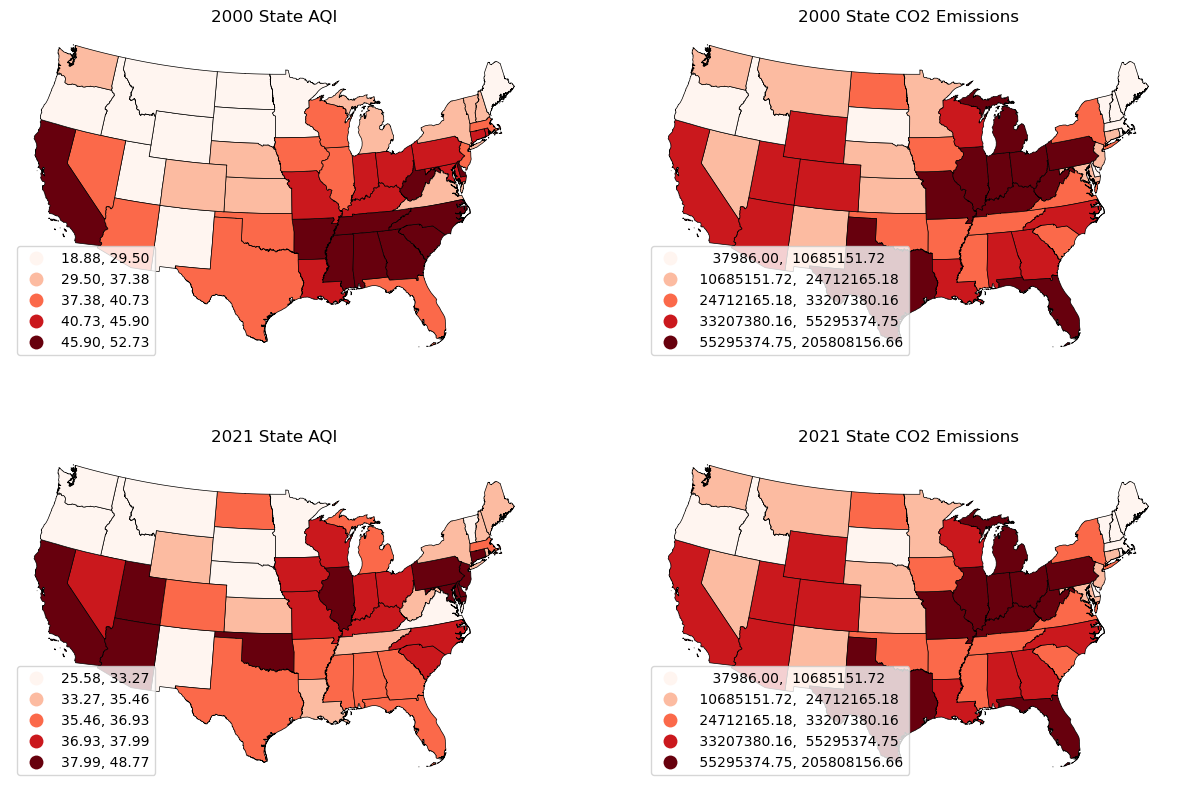

In [103]:

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

state_aqi_2000_gdf.plot(column='Median AQI', ax=axs[0,0], legend=True, scheme='quantiles',
                edgecolor='black', k=5, linewidth=0.5, cmap ='Reds', legend_kwds={'loc':'lower left'})

state_aqi_2000_gdf.plot(column='STCO2AN', ax=axs[0,1], legend=True, scheme='quantiles',
                edgecolor='black', k=5, linewidth=0.5, cmap ='Reds', legend_kwds={'loc':'lower left'})

state_aqi_2021_gdf.plot(column='Median AQI', ax=axs[1,0], legend=True, scheme='quantiles',
                edgecolor='black', k=5, linewidth=0.5, cmap ='Reds', legend_kwds={'loc':'lower left'})

state_aqi_2021_gdf.plot(column='STCO2AN', ax=axs[1,1], legend=True, scheme='quantiles',
                edgecolor='black', k=5, linewidth=0.5, cmap ='Reds', legend_kwds={'loc':'lower left'})

axs[0,0].set_title('2000 State AQI')
axs[0,1].set_title('2000 State CO2 Emissions')
axs[1,0].set_title('2021 State AQI')
axs[1,1].set_title('2021 State CO2 Emissions')
axs[0,0].axis("off")
axs[0,1].axis("off")
axs[1,0].axis("off")
axs[1,1].axis("off")
plt.show()

## States With the Most Amount of Unhealthy Days

Now lets view the states which ranked among the top 3 for the most amount of unhealthy days

In [ ]:
air2021 = airdf2021.groupby('State')['Good Days', 'Moderate Days', 'Unhealthy Days'].mean().reset_index()
daysrating2021 = state_gdf.merge(air2021, left_on='NAME', right_on='State', how='left')
top_3_unhealthy_states2021 = daysrating2021.sort_values(by="Unhealthy Days", ascending=False).head(3)

air2000 = airdf2000.groupby('State')['Good Days', 'Moderate Days', 'Unhealthy Days'].mean().reset_index()
daysrating2000 = state_gdf.merge(air2000, left_on='NAME', right_on='State', how='left')
top_3_unhealthy_states2000 = daysrating2000.sort_values(by="Unhealthy Days", ascending=False).head(3)



### Let's plot them...

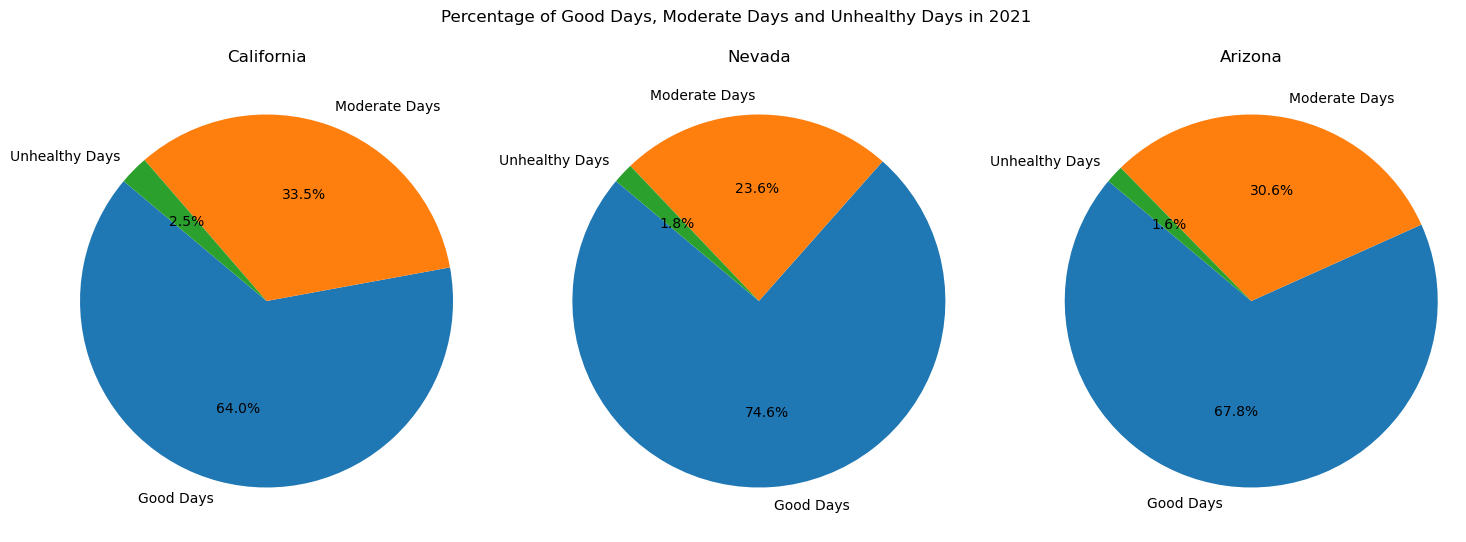

In [105]:
states2021 = ['California', 'Nevada', 'Arizona']
good_days = top_3_unhealthy_states2021['Good Days'].tolist()
moderate_days = top_3_unhealthy_states2021['Moderate Days'].tolist()
unhealthy_days = top_3_unhealthy_states2021['Unhealthy Days'].tolist()

labels = ['Good Days', 'Moderate Days', 'Unhealthy Days']

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 
fig.suptitle('Percentage of Good Days, Moderate Days and Unhealthy Days in 2021')

for i, ax in enumerate(axs):
    sizes = [good_days[i], moderate_days[i], unhealthy_days[i]]
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.axis('equal') 
    ax.set_title(states2021[i])

plt.show()

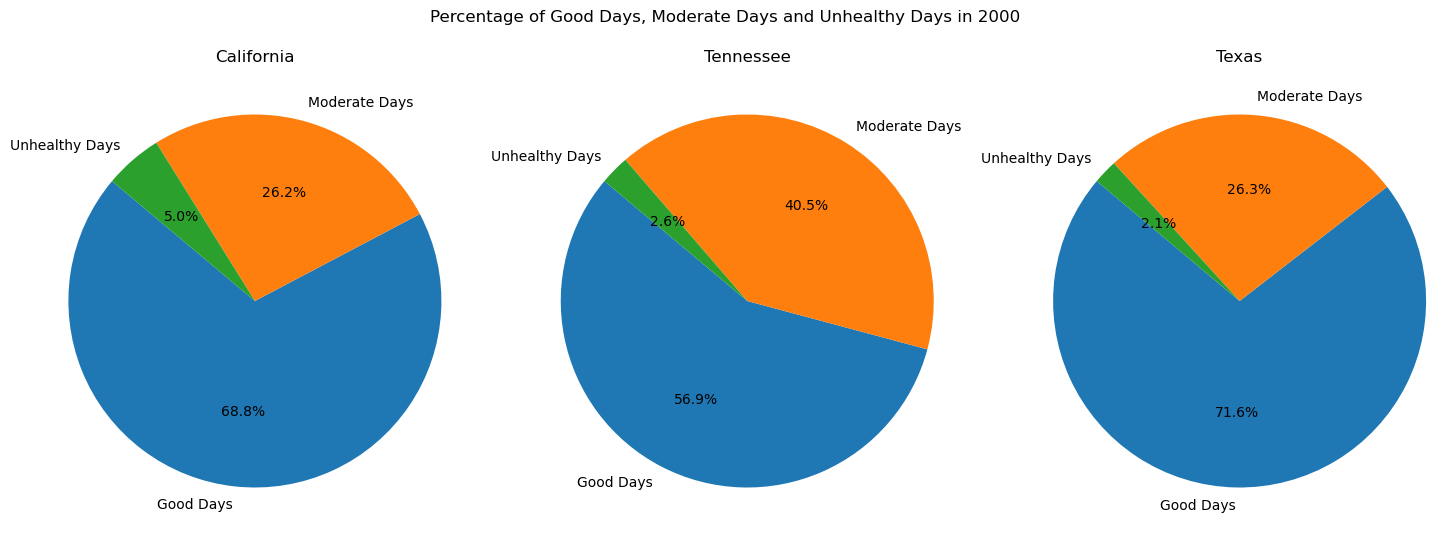

In [106]:
states2000 = ['California', 'Tennessee', 'Texas']
good_days = top_3_unhealthy_states2000['Good Days'].tolist()
moderate_days = top_3_unhealthy_states2000['Moderate Days'].tolist()
unhealthy_days = top_3_unhealthy_states2000['Unhealthy Days'].tolist()

labels = ['Good Days', 'Moderate Days', 'Unhealthy Days']

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 
fig.suptitle('Percentage of Good Days, Moderate Days and Unhealthy Days in 2000')


for i, ax in enumerate(axs):
    sizes = [good_days[i], moderate_days[i], unhealthy_days[i]]
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.axis('equal') 
    ax.set_title(states2000[i])

plt.show()

## Results & Conclusions

From our research and evaluation, we have come to a number of conclusions based on our results.

The number of generators per state is almost directly proportional to the amount of CO2 each state produces. Our interactive graph shows that Texas has the highest number of generators and CO2 emissions in the United States. Based on this information, we expected Texas to have the worst air quality, but as we later found, this was different.

From our research into each plant's CO2, NOx, and SO2 production, it is clear that coal produces far more greenhouse gases than gas plants. Based on this information, we expected that states with a large amount of coal plants would have worse air quality, but as we began exploring the AQI data, we found this was not the case.

On a side note, we wanted to investigate the amount of CO2 plants produce per person in each state. Wyoming had the highest level, with 35 Tons per person. This is unsurprising as Wyoming contained roughly the same number of generators as states such as Oregon and Maryland, despite only having a population of 578,000, which is compared to Oregon's 4.26 million and Maryland's 6.165 million. This gives us an insight into how Wyoming is steadily becoming an industrial haven and may experience gradually worse AQI levels in years to come.

Finally, after reviewing the percentage of 'Good Days,' 'Moderate Days', and 'Unhealthy Days' in 2000 and 2021, we were surprised as the results contradicted our previous assumptions. As mentioned earlier, states with large amounts of coal plants had considerably higher levels of CO2 emissions compared to states with large amounts of gas plants (Illinois vs. California). From this, we expected states with large amounts of coal plants would have worse AQI than states with large amounts of gas plants. This was not the case as California and Arizona, which have very few coal plants, actually ended up ranking number 1 and 3, having the most 'Unhealthy Days' in 2021. California has remained number 1 since 2000 for the most Unhealthy Days' in the United States. Even Texas, which has the highest number of generators in the country in 2021, is not in the top 3 of most 'Unhealthy Days' in the US. 

Our data shows how CO2 emissions correlate to each state's AQI, but other factors must be considered. States such as Arizona and Nevada are not 'Fossil Fuel Giants' yet have some of America's worst AQI. Furthermore, California, which currently has the most electric vehicles in the country, is still the worst state in America for AQI. Hopefully, in the next few years, California's pledge to EV reduce their AQI.

## Citations

Cetin, Mehmet. "Change of Air Quality in Kastamonu City in Terms of Particulate Matter and CO2 Amount." ResearchGate, 2017, www.researchgate.net/profile/Mehmet-Cetin-4/publication/319242485_Change_of_air_quality_in_kastamonu_city_in_terms_of_particulate_matter_and_CO2_amount/links/599d586d45851574f4b2ffce/Change-of-air-quality-in-kastamonu-city-in-terms-of-particulate-matter-and-CO2-amount.pdf. Accessed 27 Feb. 2024.

Karaca, Ferhat, et al. "Assessment of Spatial and Temporal Distribution of Air Pollution by Particulate Matter and CO2 in Kastamonu City." International Journal of Environmental Research and Public Health, vol. 17, no. 10, May 2020, p. 3733 

Liu, Junfeng, et al. "High-resolution Global Contiguous SIF Observations Derived from OCO-2 SIF and MODIS Reflectance Data." Nature Communications, vol. 6, no. 1, July 2015

Carslaw, David C., et al. "The Diminishing Importance of Nitrogen Dioxide Emissions from Road Vehicle Exhaust." Atmospheric Environment: X, vol. 1, 2019, 100002, ISSN 2590-1621, 

Xu A, Xiang C. Assessment of the Emission Characteristics of Major States in the United States using Satellite Observations of CO2, CO, and NO2. Atmosphere. 2024; 15(1):11. https://doi.org/10.3390/atmos15010011